# Phase 1 Project: Microsoft Movie Analysis
**Author:** Mitchell Ren
***

## Overview

This Microsoft Movie Analysis seeks to answer the following question: Which types of movies are currently performing best at the box office, and how should Microsoft use this information to break into the market?

The analysis merges data from IMDB and The Numbers to investigate movie genre performance based on key performance indicators. I gave each movie a score based on these indicators and then stack-ranked each one against the rest using percentiles. Finally, I categorized each movie by genre and used bar chart visualization to identify the top 5 performing genres.

I found the top 5 genres to be:
1. Adventure
2. Biography
3. Action
4. Mystery
5. Animation

My recommendation to Microsoft is that the new studio should focus its resources on these 5 main genres to start. I took my analysis one step further by identifying budget ranges and the top talent - including writers, directors, and actors - within each of these categories.

## Business Problem

Microsoft wants to break into the Movie-making business. However, the company has no prior experience doing so. I am tasked with evaluating the market and providing a recommendation on how to proceed.

***
Analysis Questions:
* What are the top performing genres?
* What are the key performance indicators for individual movies? 
* How can we take all KPIs into consideration? 
* Who contributes most to these KPIs? 

***


We first need to understand the market and what movies have been successful. We have metrics in our data that indicate successs in a few different ways. It is important for us to consider at least a few of these metrics so as to ensure our analysis is not too one-dimensional. Once we have a better understanding of categorical trends, we can then focus the rest of our analysis on those categories.


## Data Understanding

I will be using two datasets in this analysis - the first being IMDB data stored in a SQLite DB, and the second being a CSV file from The Numbers. The IMDB data gives us information on movie attributes such as: title, genre, runtime, and start year. It also gives us information on movie performance (i.e. average rating and number of votes). Finally, it gives us access to movie talent which we will use to round out our recommendation. The Numbers data gives us access to budget and revenue for each movie which will allow us to calculate Return on Investment.

It is important to note that these datasets do not include the same number of movies. That is, in joining the data we will lose a large number of movies from our analysis. However, I believe the number of movies we are left with is still significant enough to glean insights from. The ROI numbers are crucial. 


## Data Preparation

I started by investigating the IMDB tables. I found movie_basics and movie_ratings to be the most useful datatsets to start with because they contain both attributes and metrics.

The main variables I was interested in were movie_id, primary_title, genres, averagerating, and numvotes. Once I joined in budget and revenue data from The Numbers, I was able to create an ROI variable. Finally, I created ranking variables for each KPI.

I dropped any rows with null values in the genres column. I felt this was an appropriate course of action because genre was the basis for my categorical analysis. I also dropped many rows in joining data between IMDB datasets and The Numbers dataset. Although this cut the population size down significantly, I still felt there was enough data to produce accurate findings.

In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import sqlite3

%matplotlib inline

In [3]:
# Connecting to the SQLite IMDB database 
conn = sqlite3.connect('Data/im.db')
cur = conn.cursor()

In [4]:
# Joining the movie_basics and movie_ratings tables in the IMDB SQLite database
joined_imdb_df = pd.DataFrame(
    data=cur.execute("""SELECT *
    FROM movie_basics as mb
    LEFT JOIN movie_ratings as mr
    ON mb.movie_id = mr.movie_id;""").fetchall(),
    columns=[x[0] for x in cur.description])

joined_imdb_df.columns = ['movie_id', 
                          'primary_title', 
                          'original_title', 
                          'start_year', 
                          'runtime_minutes', 
                          'genres', 
                          'mr.movie_id',
                          'average_rating',
                          'num_votes']

joined_imdb_df.head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,mr.movie_id,average_rating,num_votes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,tt0069049,6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",tt0069204,6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",tt0100275,6.5,119.0


In [4]:
# Investigating null values from table join
joined_imdb_df_joinnulls = pd.isnull(joined_imdb_df['mr.movie_id'])
join_nulls = joined_imdb_df[joined_imdb_df_joinnulls]

print('IMDB Join:', len(joined_imdb_df), 'rows')
print('Movie ID nulls:', len(join_nulls), 'rows')

# Dropping null values from table join
joined_imdb_df_dropped_joinnulls = joined_imdb_df.drop(join_nulls.index)
joined_imdb_df_dropped_joinnulls.reset_index()

print('IMDB Join (-) Movie ID nulls:', len(joined_imdb_df_dropped_joinnulls), 'rows')

# Investigating null values from genre column
joined_imdb_df_genrenulls = pd.isnull(joined_imdb_df_dropped_joinnulls['genres'])
genre_nulls = joined_imdb_df_dropped_joinnulls[joined_imdb_df_genrenulls]

print('Genre nulls:', len(genre_nulls), 'rows')

# Dropping null values from genre column
joined_imdb_clean = joined_imdb_df_dropped_joinnulls.drop(genre_nulls.index)

print('IMDB Join (-) Movie ID and Genre nulls', len(joined_imdb_clean), 'rows')

IMDB Join: 146144 rows
Movie ID nulls: 72288 rows
IMDB Join (-) Movie ID nulls: 73856 rows
Genre nulls: 804 rows
IMDB Join (-) Movie ID and Genre nulls 73052 rows


In [5]:
# Reading in data from The Numbers .csv dataset

the_numbers = pd.read_csv('/Users/mitchellren/Documents/Flatiron/phase_1/Microsoft-Movie-Analysis/zippedData/tn.movie_budgets.csv.gz')
the_numbers.head(5)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [6]:
# Joining The Numbers budget & revenue data to IMDB ratings data

joined_df = joined_imdb_clean.merge(the_numbers, how = 'inner', left_on = 'primary_title', right_on = 'movie')
joined_df.head(5)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,mr.movie_id,average_rating,num_votes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",tt0249516,1.9,8248.0,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",tt0337692,6.1,37886.0,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"
2,tt4339118,On the Road,On the Road,2014,89.0,Drama,tt4339118,6.0,6.0,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"
3,tt5647250,On the Road,On the Road,2016,121.0,Drama,tt5647250,5.7,127.0,17,"Mar 22, 2013",On the Road,"$25,000,000","$720,828","$9,313,302"
4,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",tt0359950,7.3,275300.0,37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183"


## Data Modeling

I started my analysis by combining two tables found in the IMDB SQlite database: movie_basics and movie_ratings. This joined dataset served as the basis for my categorical analysis (movie ratings by genre). Initially, I was just looking at average rating, and then I realized that there were large variances in number of votes. I started to question the validity of purely relying on average rating, because intuitively a movie with a 7.0 rating with only 10 votes should not necessarily be considered equal to a movie with a 7.0 rating with 10,000 votes. I then realized that number of votes should also be factored into my analysis as an indicator of popularity.

I then joined in another dataset - a CSV file from The Numbers which includes budget and revenue. To me, this is a crucial part of the analysis because at the end of the day, businesses are driven by Return on Investment. Now with average rating, number of votes, and ROI - I created a scoring system that ranked each movie against the others using percentiles in each category. I then weighted these 3 factors equally so as to take a more balanced approach than simply choosing one KPI to evaluate success.

With each movie scored and ranked against the rest, I then aggregated by genre to pinpoint the most successful ones. Finally, I found budget ranges and talent pools for the top 5 performing genres.

In [7]:
# Converting Budget and Revenue to integers for calculations
joined_df['production_budget'] = joined_df['production_budget'].str[1:].replace(",","", regex = True).astype(int)
joined_df['domestic_gross'] = joined_df['domestic_gross'].str[1:].replace(",","", regex = True).astype(int)
joined_df['worldwide_gross'] = joined_df['worldwide_gross'].str[1:].replace(",","", regex = True).astype(int)

joined_df.dtypes

movie_id              object
primary_title         object
original_title        object
start_year             int64
runtime_minutes      float64
genres                object
mr.movie_id           object
average_rating       float64
num_votes            float64
id                     int64
release_date          object
movie                 object
production_budget      int64
domestic_gross         int64
worldwide_gross        int64
dtype: object

In [8]:
# Ranking each performance category by percentiles: Rating, Number of Votes, ROI
# Averaging those percentile scores into an overall movie score out of 100
joined_df['ROI'] = joined_df['worldwide_gross'] - joined_df['production_budget']
joined_df['average_rating_rank'] = joined_df.average_rating.rank(pct = True)
joined_df['num_votes_rank'] = joined_df.num_votes.rank(pct = True)
joined_df['ROI_rank'] = joined_df.ROI.rank(pct = True)
joined_df['Overall_Movie_Score'] = (joined_df[['average_rating_rank','num_votes_rank','ROI_rank']].mean(axis = 1) * 100).round()

joined_df[['primary_title',
           'average_rating', 
           'average_rating_rank', 
           'num_votes', 
           'num_votes_rank',
           'production_budget', 
           'worldwide_gross', 
           'ROI', 
           'ROI_rank', 
           'Overall_Movie_Score']].tail(5)

,primary_title,average_rating,average_rating_rank,num_votes,num_votes_rank,production_budget,worldwide_gross,ROI,ROI_rank,Overall_Movie_Score
2862,Richard III,9.1,0.998256,28.0,0.128357,9200000,4199334,-5000666,0.182072,44.0
2863,Heroes,7.3,0.828566,7.0,0.028078,400000,655538,255538,0.400767,42.0
2864,Push,7.3,0.828566,33.0,0.139344,38000000,49678401,11678401,0.514475,49.0
2865,Unplanned,6.3,0.472445,5945.0,0.477503,6000000,18107621,12107621,0.518661,49.0
2866,The Terrorist,6.0,0.362574,6.0,0.017614,25000,195043,170043,0.397977,26.0


In [9]:
# Consolidating the genre column, since there are instances of more than one genre listed
# Assuming that the first-listed genre is the most important descriptor - for example, drama seems to be a catch-all category

joined_df['Primary_Genre'] = joined_df['genres'].str.split(',').str[0]
joined_df[['genres', 'Primary_Genre']].head(2)

,genres,Primary_Genre
0,"Action,Animation,Comedy",Action
1,"Adventure,Drama,Romance",Adventure


In [10]:
pivot = pd.pivot_table(joined_df, 
                       values = 'Overall_Movie_Score',
                       index = 'Primary_Genre', 
                       aggfunc = np.mean)
pivot_reset = pivot.reset_index()
pivot_reset

,Primary_Genre,Overall_Movie_Score
0,Action,56.382540
1,Adventure,60.270642
2,Animation,49.680000
3,Biography,58.774390
4,Comedy,48.882470
5,Crime,48.931507
6,Documentary,45.926380
7,Drama,45.515152
8,Family,37.933333
9,Fantasy,42.833333


In [11]:
pivot_reset.columns

Index(['Primary_Genre', 'Overall_Movie_Score'], dtype='object')

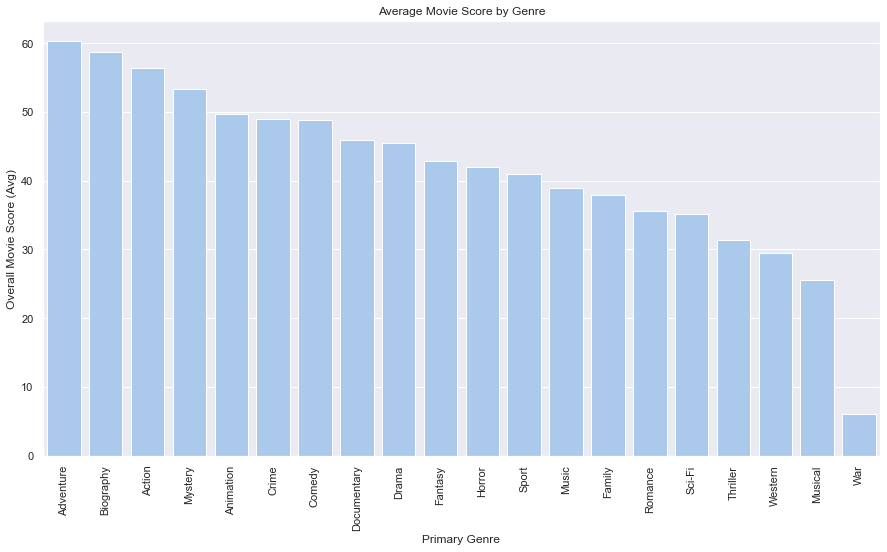

In [33]:
plt.figure(figsize = (15,8))

sns.set_color_codes("pastel")


ax = sns.barplot(x = 'Primary_Genre', 
                 y = 'Overall_Movie_Score', 
                 data = pivot_reset, order = pivot_reset.sort_values('Overall_Movie_Score', ascending = False).Primary_Genre, 
                 color = 'b')
ax.set_xlabel('Primary Genre')
ax.set_ylabel('Overall Movie Score (Avg)')
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.set_title('Average Movie Score by Genre')
fig1 = ax.get_figure()
fig1.savefig('Genre_Performance.png');

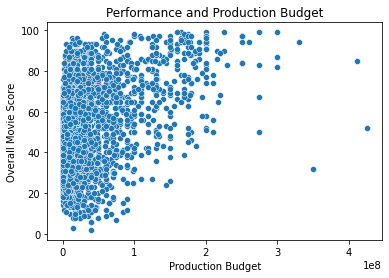

In [13]:
# Exploring the relationship between Production Budget and Overall Movie Score

ax = sns.scatterplot(data=joined_df, x='production_budget', y='Overall_Movie_Score')
ax.set_ylabel('Overall Movie Score')
ax.set_xlabel('Production Budget')
ax.set_title('Performance and Production Budget')
fig2 = ax.get_figure()
fig2.savefig('Budget_Performance.png');

Production Budget Mean (Millions): 71.8
Production Budget Median (Millions): 72.0
Production Budget Standard Deviation (Millions): 50.60313999919153


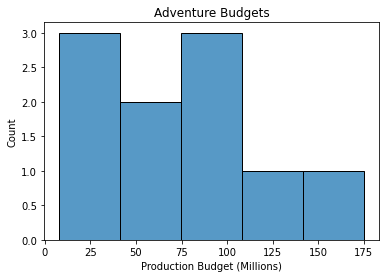

In [14]:
# Using measures of central tendency and dispersion to determine a budget range recommendation for the Adventure category

Adventure_subset_df = joined_df[joined_df['Primary_Genre'] == 'Animation'].sort_values('Overall_Movie_Score', ascending = False).head(10)
print('Production Budget Mean (Millions):', Adventure_subset_df['production_budget'].mean() / 1000000)
print('Production Budget Median (Millions):', Adventure_subset_df['production_budget'].median() / 1000000)
print('Production Budget Standard Deviation (Millions):', Adventure_subset_df['production_budget'].std()/ 1000000);

Adventure_budgets = Adventure_subset_df['production_budget'] / 1000000
ax = sns.histplot(data = Adventure_budgets, bins = 5)
ax.set_xlabel('Production Budget (Millions)')
ax.set_title('Adventure Budgets')
fig3 = ax.get_figure()
fig3.savefig('Adventure_Budgets.png');

Production Budget Mean (Millions): 47.65
Production Budget Median (Millions): 42.25
Production Budget Standard Deviation (Millions): 27.355732691907765


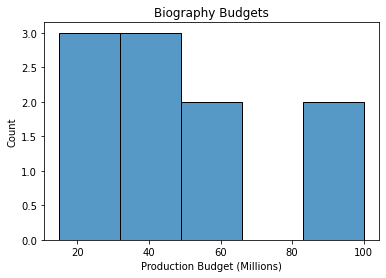

In [15]:
# Using measures of central tendency and dispersion to determine a budget range recommendation for the Biography category

Biography_subset_df = joined_df[joined_df['Primary_Genre'] == 'Biography'].sort_values('Overall_Movie_Score', ascending = False).head(10)
print('Production Budget Mean (Millions):', Biography_subset_df['production_budget'].mean() / 1000000)
print('Production Budget Median (Millions):', Biography_subset_df['production_budget'].median() / 1000000)
print('Production Budget Standard Deviation (Millions):', Biography_subset_df['production_budget'].std()/ 1000000);

Biography_budgets = Biography_subset_df['production_budget'] / 1000000
ax = sns.histplot(data = Biography_budgets, bins = 5)
ax.set_xlabel('Production Budget (Millions)')
ax.set_title('Biography Budgets')
fig4 = ax.get_figure()
fig4.savefig('Biography_Budgets.png');

Production Budget Mean (Millions): 194.5
Production Budget Median (Millions): 190.0
Production Budget Standard Deviation (Millions): 72.14222064782868


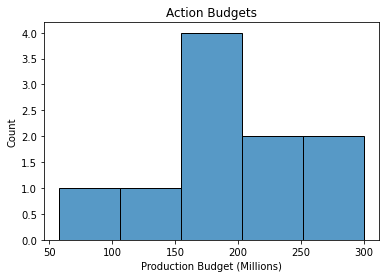

In [16]:
# Using measures of central tendency and dispersion to determine a budget range recommendation for the Action category

Action_subset_df = joined_df[joined_df['Primary_Genre'] == 'Action'].sort_values('Overall_Movie_Score', ascending = False).head(10)
print('Production Budget Mean (Millions):', Action_subset_df['production_budget'].mean() / 1000000)
print('Production Budget Median (Millions):', Action_subset_df['production_budget'].median() / 1000000)
print('Production Budget Standard Deviation (Millions):', Action_subset_df['production_budget'].std() / 1000000);

Action_budgets = Action_subset_df['production_budget'] / 1000000
ax = sns.histplot(data = Action_budgets, bins = 5)
ax.set_xlabel('Production Budget (Millions)')
ax.set_title('Action Budgets')
fig5 = ax.get_figure()
fig5.savefig('Action_Budgets.png');

Production Budget Mean (Millions): 33.215
Production Budget Median (Millions): 26.0
Production Budget Standard Deviation (Millions): 30.90280506865212


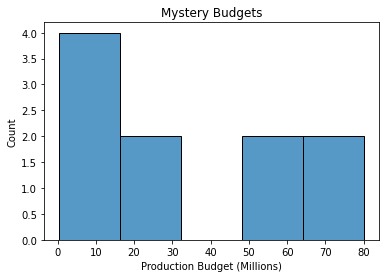

In [17]:
# Using measures of central tendency and dispersion to determine a budget range recommendation for the Mystery category

Mystery_subset_df = joined_df[joined_df['Primary_Genre'] == 'Mystery'].sort_values('Overall_Movie_Score', ascending = False).head(10)
print('Production Budget Mean (Millions):', Mystery_subset_df['production_budget'].mean() / 1000000)
print('Production Budget Median (Millions):', Mystery_subset_df['production_budget'].median() / 1000000)
print('Production Budget Standard Deviation (Millions):', Mystery_subset_df['production_budget'].std() / 1000000);

Mystery_budgets = Mystery_subset_df['production_budget'] / 1000000
ax = sns.histplot(data = Mystery_budgets, bins = 5)
ax.set_xlabel('Production Budget (Millions)')
ax.ticklabel_format(style = 'plain', axis = 'x')
ax.set_title('Mystery Budgets')
fig6 = ax.get_figure()
fig6.savefig('Mystery_Budgets.png');

Production Budget Mean (Millions): 71.8
Production Budget Median (Millions): 72.0
Production Budget Standard Deviation (Millions): 50.60313999919153


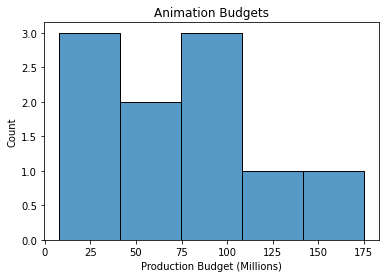

In [18]:
# Using measures of central tendency and dispersion to determine a budget range recommendation for the Animation category

Animation_subset_df = joined_df[joined_df['Primary_Genre'] == 'Animation'].sort_values('Overall_Movie_Score', ascending = False).head(10)
print('Production Budget Mean (Millions):', Animation_subset_df['production_budget'].mean() / 1000000)
print('Production Budget Median (Millions):', Animation_subset_df['production_budget'].median() / 1000000)
print('Production Budget Standard Deviation (Millions):', Animation_subset_df['production_budget'].std() / 1000000);

Animation_budgets = Animation_subset_df['production_budget'] / 1000000
ax = sns.histplot(data = Animation_budgets, bins = 5)
ax.set_xlabel('Production Budget (Millions)')
ax.set_title('Animation Budgets')
fig7 = ax.get_figure()
fig7.savefig('Animation_Budgets.png');

In [19]:
# Investigating writers and directors 
movie_principals_df = pd.DataFrame(
    data=cur.execute("""SELECT
        pri.movie_id,
        pri.person_id,
        pri.category,
        per.primary_name,
        per.birth_year
    FROM principals as pri
    LEFT JOIN persons as per
        ON per.person_id = pri.person_id
    WHERE (category = 'director' OR category = 'writer' OR category = 'actor') 
    AND death_year is null
    AND birth_year is not null
    ORDER BY movie_id;""").fetchall(),
    columns=[x[0] for x in cur.description])

movie_principals_df

,movie_id,person_id,category,primary_name,birth_year
0,tt0063540,nm0474801,actor,Dilip Kumar,1922.0
1,tt0063540,nm0347899,writer,Gulzar,1936.0
2,tt0066787,nm0451809,actor,Arun Khopkar,1945.0
3,tt0069049,nm0000953,actor,Peter Bogdanovich,1939.0
4,tt0069204,nm2147526,actor,Asrani,1941.0
...,...,...,...,...,...
116547,tt9915790,nm3056725,actor,Paran Banerjee,1940.0
116548,tt9915872,nm2507310,writer,Ryuho Okawa,1956.0
116549,tt9916190,nm0302466,actor,Patrick Gallagher,1968.0
116550,tt9916428,nm3370295,actor,Shenyang Xiao,1981.0


In [20]:
# Consolidating dataset by movie_id to create list of talent per movie
movie_principals_grouped = movie_principals_df.groupby('movie_id').agg(pd.Series.tolist).reset_index()
movie_principals_grouped.head(5)

,movie_id,person_id,category,primary_name,birth_year
0,tt0063540,"[nm0474801, nm0347899]","[actor, writer]","[Dilip Kumar, Gulzar]","[1922.0, 1936.0]"
1,tt0066787,[nm0451809],[actor],[Arun Khopkar],[1945.0]
2,tt0069049,[nm0000953],[actor],[Peter Bogdanovich],[1939.0]
3,tt0069204,"[nm2147526, nm0347899]","[actor, writer]","[Asrani, Gulzar]","[1941.0, 1936.0]"
4,tt0100275,"[nm0016013, nm0721280, nm0765384]","[actor, actor, director]","[Luis Alarcón, Francisco Reyes, Valeria Sarmie...","[1929.0, 1954.0, 1948.0]"


In [21]:
# Joining talent dataset with the IMDB ratings dataset used for the genre analysis

talent_join = joined_df.merge(movie_principals_grouped, 
                              how = 'inner', 
                              left_on = 'movie_id', 
                              right_on = 'movie_id')

talent_join[['primary_title','person_id','category','primary_name']].head(2)

,primary_title,person_id,category,primary_name
0,Foodfight!,"[nm0000221, nm0440415, nm0923312, nm0295165, n...","[actor, director, writer, writer, writer]","[Charlie Sheen, Lawrence Kasanoff, Joshua Wexl..."
1,On the Road,"[nm0727165, nm1330560, nm0758574, nm1433580]","[actor, actor, director, writer]","[Sam Riley, Garrett Hedlund, Walter Salles, Jo..."


In [46]:
# Creating new subsest dataset filtered for top 5 genres

genre_pivot = pivot.sort_values('Overall_Movie_Score', ascending = False).reset_index().head(5)
top_5_genres = list(genre_pivot['Primary_Genre'])
top_5_genres

talent_join_filtered = talent_join[talent_join['Primary_Genre'].isin(top_5_genres)]

talent_join_filtered['Primary_Genre'].unique()

array(['Action', 'Adventure', 'Biography', 'Animation', 'Mystery'],
      dtype=object)

In [23]:
# Creating dataframes for each top 5 genre and then identifying the top talent per genre

Animation_df = pd.DataFrame(talent_join[talent_join['Primary_Genre'] == 'Animation'])
Adventure_df = pd.DataFrame(talent_join[talent_join['Primary_Genre'] == 'Adventure'])
Biography_df = pd.DataFrame(talent_join[talent_join['Primary_Genre'] == 'Biography'])
Action_df = pd.DataFrame(talent_join[talent_join['Primary_Genre'] == 'Action'])
Mystery_df = pd.DataFrame(talent_join[talent_join['Primary_Genre'] == 'Mystery'])

In [24]:
# Creating a new DataFrame with just the name and titles for talent associated with the top 10 movies in that genre

def pull_talent_info(genre_df):
    """ Function takes a genre dataframe as input 
    and returns a new dataframe with genre-specific talent details
    """
    subset_genre_df = genre_df.sort_values('Overall_Movie_Score', ascending = False).head(10)

    genre_df_names = []
    genre_df_categories = []

    for name in subset_genre_df['primary_name']:
        for individual in name:
            genre_df_names.append(individual)

    for category in subset_genre_df['category']:
        for individual_category in category:
            genre_df_categories.append(individual_category)
            
    genre_df_talent = {'Name': genre_df_names, 'Role' : genre_df_categories}
    genre_df_talent_df = pd.DataFrame(genre_df_talent)

    return genre_df_talent_df.drop_duplicates()

In [25]:
# Using the pull_talent_info function for the Mystery genre

New_Mystery_df = pull_talent_info(Mystery_df)
New_Mystery_df['Genre'] = 'Mystery'

New_Mystery_df.head(5)

,Name,Role,Genre
0,Leonardo DiCaprio,actor,Mystery
1,Mark Ruffalo,actor,Mystery
2,Ben Kingsley,actor,Mystery
3,Martin Scorsese,director,Mystery
4,Laeta Kalogridis,writer,Mystery


In [34]:
# Using the pull_talent_info function for the Adventure genre

New_Adventure_df = pull_talent_info(Adventure_df)
New_Adventure_df['Genre'] = 'Adventure'

New_Adventure_df.head(5)

,Name,Role,Genre
0,Matthew McConaughey,actor,Adventure
1,Christopher Nolan,director,Adventure
2,Jonathan Nolan,writer,Adventure
3,Tom Hanks,actor,Adventure
4,Tim Allen,actor,Adventure


In [35]:
# Using the pull_talent_info function for the Animation genre

New_Animation_df = pull_talent_info(Animation_df)
New_Animation_df['Genre'] = 'Animation'
New_Animation_df.head(5)

,Name,Role,Genre
0,Steve Carell,actor,Animation
1,Jason Segel,actor,Animation
2,Russell Brand,actor,Animation
3,Pierre Coffin,director,Animation
4,Cinco Paul,writer,Animation


In [36]:
# Using the pull_talent_info function for the Biography genre

New_Biography_df = pull_talent_info(Biography_df)
New_Biography_df['Genre'] = 'Biography'
New_Biography_df.head(5)

,Name,Role,Genre
0,Leonardo DiCaprio,actor,Biography
1,Jonah Hill,actor,Biography
2,Matthew McConaughey,actor,Biography
3,Martin Scorsese,director,Biography
4,Terence Winter,writer,Biography


In [37]:
# Using the pull_talent_info function for the Action genre

New_Action_df = pull_talent_info(Action_df)
New_Action_df['Genre'] = 'Action'
New_Action_df.head(5)

,Name,Role,Genre
0,Christian Bale,actor,Action
1,Tom Hardy,actor,Action
2,Gary Oldman,actor,Action
3,Christopher Nolan,director,Action
4,Jonathan Nolan,writer,Action


In [30]:
# Combining genre-specific talent dataframes into one consolidated version

Consolidated_Talent_df = pd.concat([New_Action_df, 
                                    New_Mystery_df, 
                                    New_Animation_df, 
                                    New_Adventure_df, 
                                    New_Biography_df], ignore_index = True, axis = 0)

# Consolidating duplicate rows across genres (i.e. same Director across multiple genres)
Final_Consolidated_Talent_df = Consolidated_Talent_df.groupby(['Name', 'Role']).agg(pd.Series.tolist).reset_index()

Final_Consolidated_Talent_df

,Name,Role,Genre
0,Aaron Sorkin,writer,[Biography]
1,Adam Sandler,actor,[Animation]
2,Alan Arkin,actor,[Biography]
3,Alejandro G. Iñárritu,director,[Action]
4,Allen Leech,actor,[Biography]
...,...,...,...
180,Yoshihiro Nakamura,director,[Mystery]
181,Yoshiyoshi Arakawa,actor,[Mystery]
182,Zac Efron,actor,[Biography]
183,Zak Penn,writer,[Action]


In [31]:
# Final_Consolidated_Talent_df.to_csv('Talent_List.csv', index = False)

## Evaluation

I feel that my work gives a solid starting point and general direction for Microsoft to break into the movie-making business. Given the datasets available, I honed in on what I felt to be the most important attributes and metrics. I iterated on my approach and made it less one-dimensional by introducing percentile rankings and further statistical analyses. 

I am confident enough that my results would generalize beyond the data I have, however I do recognize the limitations of my analysis. The sample size I ended up with was much smaller than I would have liked, and this could certainly lead to biases. I am confident though that this analysis would prove useful at least as a starting point for Microsoft.

## Conclusions

I recommend that Microsoft prioritize the following movie genres with noted budget ranges:

1. Adventure (47 - 97 Million USD)
2. Biography (34 - 62 Million USD)
3. Action (158 - 231 Million USD)
4. Mystery (18 - 48 Million USD)
5. Animation (47 - 97 Million USD)

Within these categories, I recommend Microsoft pursue the writers, directors, and actors listed in the Talent_List.csv file I ended my analysis with. These individuals made major contributions to the top-performing movies in our datasets.

My analysis is not fully comprehensive for the following reasons: It lacks advanced statistical analysis (regression analysis, correlation analysis, etc.) which would better help to identify the most important attributes and metrics to focus on, and the sample size is quite small in the grand scheme - only around 2k movies made it to the fully-combined dataset

In order to improve this project moving forward, I would seek out more data, and incorporate more advanced statistical analyses. I would also try to better-understand Microsoft's specific business situation (i.e. how much money they have to allocate towards this venture). 